<a href="https://colab.research.google.com/github/allispaul/audiobot/blob/main/EDA/Audiobots_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Audiobots

We're using data from [this dataset](hhttps://huggingface.co/datasets/lewtun/music_genres_small) to try and classify one thousand 30s samples of audio into one of 10 genres:

*   International        
*   Pop                  
*   Electronic           
*   Chiptune / Glitch    
*   Punk                 
*   Folk                 
*   Hip-Hop              
*   Rock                 
*   Instrumental         
*   Experimental

The data is a .parquet file containing ~30s (uncompressed?) .wav files (I have to check bit depths and sample rates still), along with song_id (does this mean anything to anyone?), and the genre from one of the 10 categories above.

We are assuming the genres are accurate. Notably, the ``International'' genre appears to contain a variety of other genres of music, and many songs can come from more than one genre. We may eliminate this class if it causes problems.

For training, we will feed the 90\% of the data into a pre-trained Transformer network from HuggingSpace, and fine-tune the network to classify one of the 10 genres above. If the architecture requries inputs of constant size, we can either pad shorter samples with 0's, or randomly clip shorter sections of longer audio streams.

This code does the following:

*   Downloads the data from Google Drive
*   (TODO) Splits the data into a CONSISTENT training and validation set. No need to create a test set until we get to the larger datasets.
*   Calculates statistics for each class, verifying the same number of tracks in each genre, and that the size of each song is similar.
*   (TODO) Determine if there's a way to analyze the average value/volume for each track.
*   (TODO) Do we want to normalize the data in any way? I suspect Electronic music will be consistently louder than Folk music, which could throw off a (dumb) model just by changing the volume.
*   (TODO) Create a simple model to predict genre from the data
*   (TODO) Turn the data into spectrograms. This should probably be done once and saved instead of on the fly, as different settings could produce drastically different pictures.

In [61]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
#from IPython.display import Audio

!pip install datasets
from datasets import load_dataset, Audio

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Alternatively, you can download the data from scratch

In [47]:
# !wget https://huggingface.co/datasets/lewtun/music_genres_small/resolve/main/data/train-00000-of-00001-63d68663287b1638.parquet?download=true
# spoopier way
songs = load_dataset("lewtun/music_genres_small", split='train')
songs = songs.cast_column("audio", Audio(sampling_rate=44100)) #resampling

songs

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 1000
})

In [89]:
genres = {
  0: "Electronic",
  1: "Rock",
  2: "Punk",
  3: "Experimental",
  4: "Hip-Hop",
  5: "Folk",
  6: "Chiptune / Glitch",
  7: "Instrumental",
  8: "Pop",
  9: "International"
}

Import the 30s version of the too short song and replace.


In [ ]:
song_786, _ = librosa.load('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Audiobots/Data/786.wav', sr = 44100)
songs[786]['audio']['array'] = song_786 # This doesn't work
# I really actually hate this dataset. Let'se see if we can't make the whole
# thing a dataframe that actually works properly, instead of this bytes trash

In [ ]:
newarray = []
for i in range(1):
  newarray = [song['array'] for song in songs['audio']])
  #songs.shard(num_shards=10, index=i) # can do this chunks at a time
  print(i)

newarray
#I have no idea what the issue is, but Colab crashes when I do this normally.
#I'm still >90% ram doing it this dum way

SyntaxError: unmatched ')' (<ipython-input-5-2ce7c8c9f10d>, line 3)

In [49]:
PATH_TO_DATA = "/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Audiobots/Data/data.parquet"

In [50]:
df = pq.read_table(PATH_TO_DATA).to_pandas()
df

,audio,song_id,genre_id,genre
0,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,11483,9,International
1,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,6824,9,International
2,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,8361,8,Pop
3,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,12269,9,International
4,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,1063,0,Electronic
...,...,...,...,...
995,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,10387,5,Folk
996,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,22075,6,Chiptune / Glitch
997,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,24724,9,International
998,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,18869,9,International


In [51]:
df = df.drop(['audio'], axis =1)
df

,song_id,genre_id,genre
0,11483,9,International
1,6824,9,International
2,8361,8,Pop
3,12269,9,International
4,1063,0,Electronic
...,...,...,...
995,10387,5,Folk
996,22075,6,Chiptune / Glitch
997,24724,9,International
998,18869,9,International


In [ ]:
df.genre.value_counts()

International        100
Pop                  100
Electronic           100
Chiptune / Glitch    100
Punk                 100
Folk                 100
Hip-Hop              100
Rock                 100
Instrumental         100
Experimental         100
Name: genre, dtype: int64

(array([100.,   0., 100.,   0., 100.,   0., 100.,   0., 100.,   0., 100.,
          0., 100.,   0., 100.,   0., 100.,   0., 100.]),
 array([0.        , 0.47368421, 0.94736842, 1.42105263, 1.89473684,
        2.36842105, 2.84210526, 3.31578947, 3.78947368, 4.26315789,
        4.73684211, 5.21052632, 5.68421053, 6.15789474, 6.63157895,
        7.10526316, 7.57894737, 8.05263158, 8.52631579, 9.        ]),
 <BarContainer object of 19 artists>)

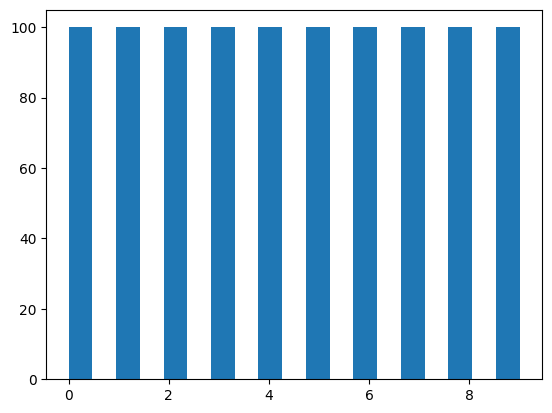

In [ ]:
plt.hist(df.genre_id, bins = 19)

In [ ]:
df.describe()

,song_id,genre_id
count,1000.000000,1000.000000
mean,12344.531000,4.500000
std,7382.361901,2.873719
min,2.000000,0.000000
25%,5789.750000,2.000000
50%,12340.500000,4.500000
75%,18724.250000,7.000000
max,24971.000000,9.000000


In [57]:
df[df['genre_id'] == 0].index #index of only electronic songs

Int64Index([  4,   8,  33,  38,  39,  56,  64,  88,  96, 101, 102, 108, 109,
            116, 125, 134, 135, 140, 141, 163, 170, 176, 182, 197, 205, 206,
            213, 219, 220, 243, 252, 260, 277, 288, 302, 319, 322, 328, 362,
            364, 370, 376, 399, 400, 405, 427, 429, 430, 433, 446, 450, 457,
            468, 478, 480, 498, 513, 521, 531, 554, 569, 581, 598, 603, 624,
            627, 647, 688, 690, 693, 711, 715, 720, 727, 742, 747, 750, 772,
            778, 783, 837, 838, 844, 847, 852, 855, 875, 876, 878, 890, 898,
            908, 911, 925, 957, 966, 973, 976, 987, 993],
           dtype='int64')

In [53]:
myindex = df[df['genre_id'] == 0].index



newarray = [np.array(song['array'], dtype = np.float32) for song in songs[myindex]['audio']]
# Oh shit, it worked! Just barely! Might try on my local machine to see if it works
# Why is this using so much ram? The whole dataset is less than half a Gig
# Just the songs should be... some subset of that. Are python lists inefficient?


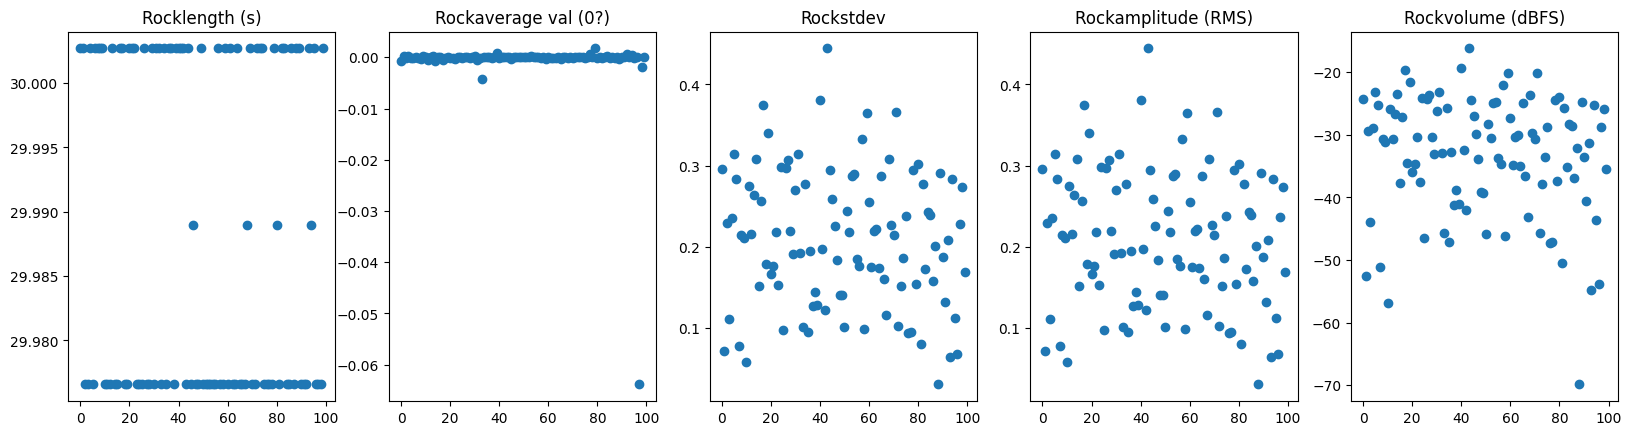

In [93]:
lengths = []
averages = []
stdevs = []
amps = []
vols = []

for song in newarray:
    lengths.append(len(song))
    averages.append(np.mean(song))
    stdevs.append(np.std(song))
    amps.append(np.sqrt(np.sum(song**2)/len(song)))
    vols.append(20*np.log(amps[-1]))

    #sounds.append(song['audio']['array'])

figure, axis = plt.subplots(1,5)
figure.set_figwidth(20)


axis[0].scatter(range(100), np.array(lengths)/44100)
axis[0].set_title("length (s)")

axis[1].scatter(range(100), averages)
axis[1].set_title("average val (0?)")

axis[2].scatter(range(100), stdevs)
axis[2].set_title("stdev")

axis[3].scatter(range(100), amps)
axis[3].set_title("amplitude (RMS)")

axis[4].scatter(range(100), vols)
axis[4].set_title("volume (dBFS)")

plt.show()

It shuold come as a surprise to nobody that stdevs and amps are essentially (but not exactly) the same.

The difference is dividing by n vs n-1, which is essentially no difference when we have hundreds of thousands of points.

Notably, volume is ALSO the "same," except logarithmically scaled, because sound is fucky.

Text(0, 0.5, 'length (s)')

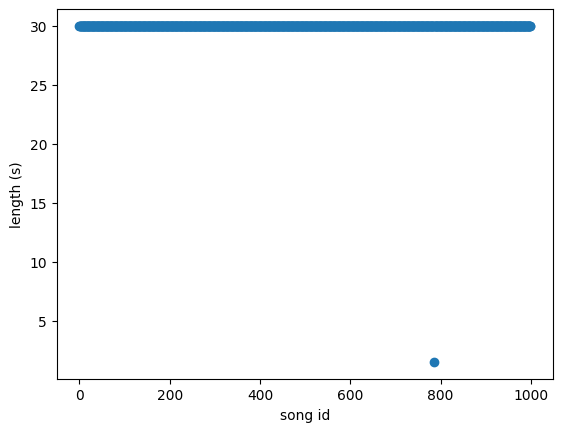

In [ ]:
#This was meant to do it for the full dataset, but is horrendously slow, and EOM errors half the time
#SOO, I'm just going to do this 10x like an idiot
lengths = []
sounds = []
averages = []
stdevs = []

for song in songs:
    lengths.append(len(song['audio']['array']))
    # Goodness fuck, this is so fucking slow. There HAS to be a better way to do this
    averages.append(np.mean(song['audio']['array']))
    stdevs.append(np.std(song['audio']['array']))

    #sounds.append(song['audio']['array'])

plt.scatter(range(1000), np.array(lengths)/44100)
plt.xlabel("song id")
plt.ylabel("length (s)")



In [95]:
def makegraphs(genre, lengths, averages, stdevs, amps, vols):

    figure, axis = plt.subplots(1,5)
    figure.set_figwidth(20)


    axis[0].scatter(range(100), np.array(lengths)/44100)
    axis[0].set_title(genres[i]+" length (s)")

    axis[1].scatter(range(100), averages)
    axis[1].set_title(genres[i]+" average val (0?)")

    axis[2].scatter(range(100), stdevs)
    axis[2].set_title(genres[i]+" stdev")

    axis[3].scatter(range(100), amps)
    axis[3].set_title(genres[i]+" amplitude (RMS)")

    axis[4].scatter(range(100), vols)
    axis[4].set_title(genres[i]+" volume (dBFS)")

    plt.show()


In [104]:
def calculatestats(genre, lengths, averages, stdevs, amps, vols):

    print("Genre: ", genres[i])
    print("the max lenth of a ", genres[i], " track is ", np.max(lengths)/44100)
    print("the min lenth of a ", genres[i], " track is ", np.min(lengths)/44100)
    print("The most DC ofset is ", np.max(np.abs(averages)))
    print("The loudest ", genres[i], " track is ", np.max(vols)," dBFS")
    print("The quietest ", genres[i], " track is ", np.min(vols)," dBFS")
    print("The average ", genres[i], " track is ", 20*np.log10(np.mean(amps))," dBFS")
    # Because decibels are logarithmic, you can't just take their mean.
    # Could do geometric mean though...



Genre:  Electronic
the max lenth of a  Electronic  track is  30.00269841269841
the min lenth of a  Electronic  track is  29.976575963718822
The most DC ofset is  0.09766897
The loudest  Electronic  track is  -7.030651190217718  dBFS
The quietest  Electronic  track is  -29.82233470117034  dBFS
The average  Electronic  track is  -13.745086353605862  dBFS


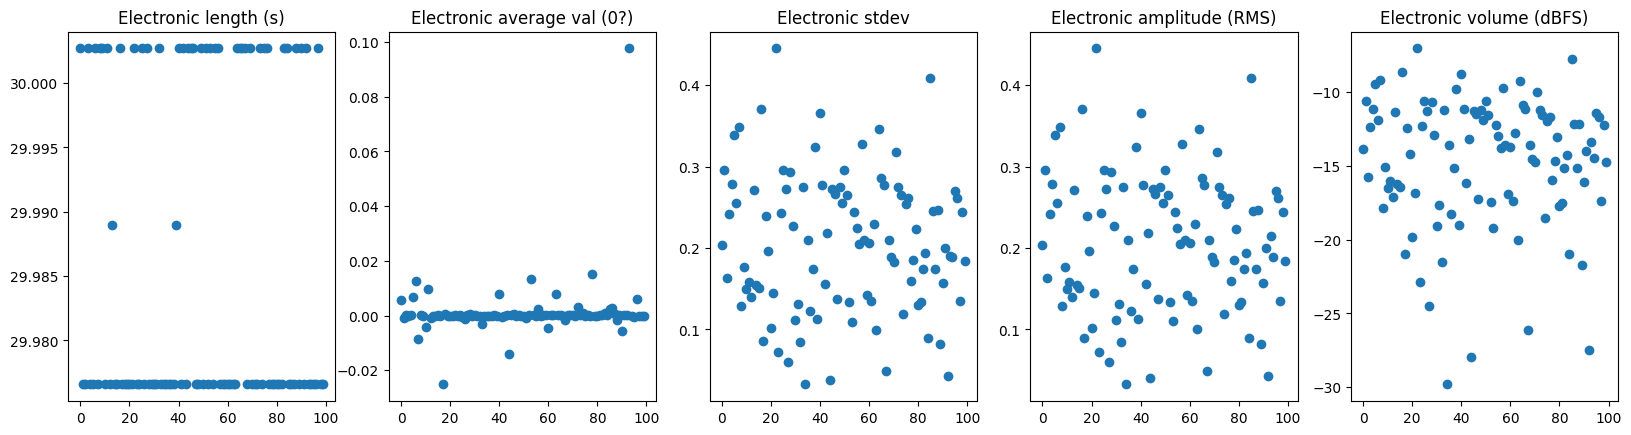

Genre:  Rock
the max lenth of a  Rock  track is  30.00269841269841
the min lenth of a  Rock  track is  29.976575963718822
The most DC ofset is  0.063889705
The loudest  Rock  track is  -7.044962406760069  dBFS
The quietest  Rock  track is  -30.350556492157036  dBFS
The average  Rock  track is  -13.599538569702448  dBFS


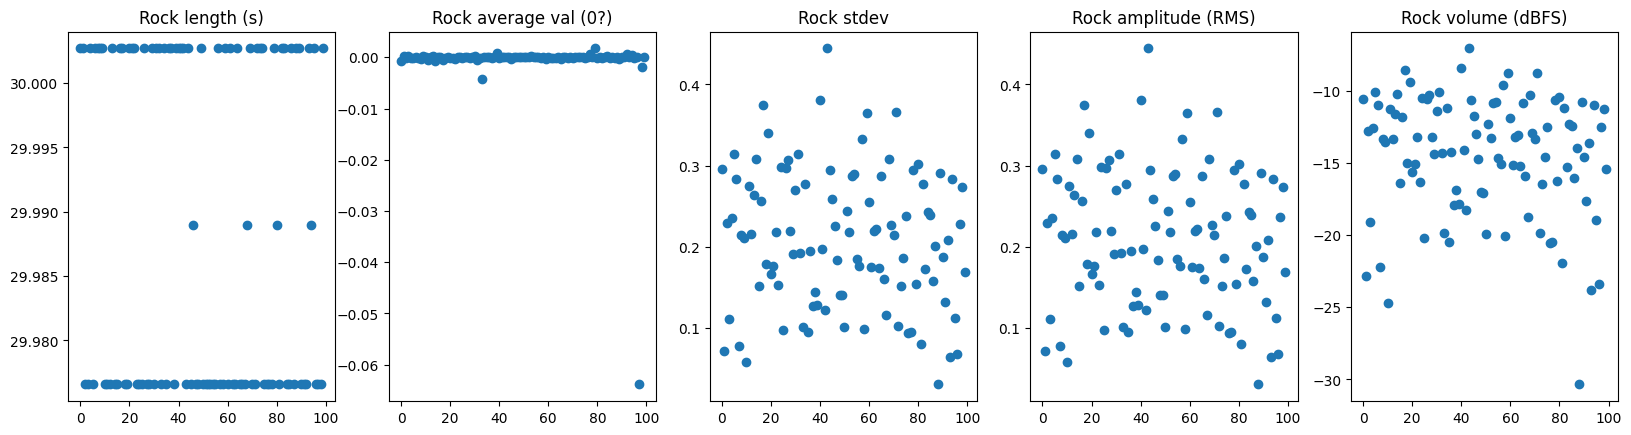

Genre:  Punk
the max lenth of a  Punk  track is  30.00748299319728
the min lenth of a  Punk  track is  29.976575963718822
The most DC ofset is  0.0053709745
The loudest  Punk  track is  -6.152185078178379  dBFS
The quietest  Punk  track is  -30.694652762837787  dBFS
The average  Punk  track is  -13.720551460321985  dBFS


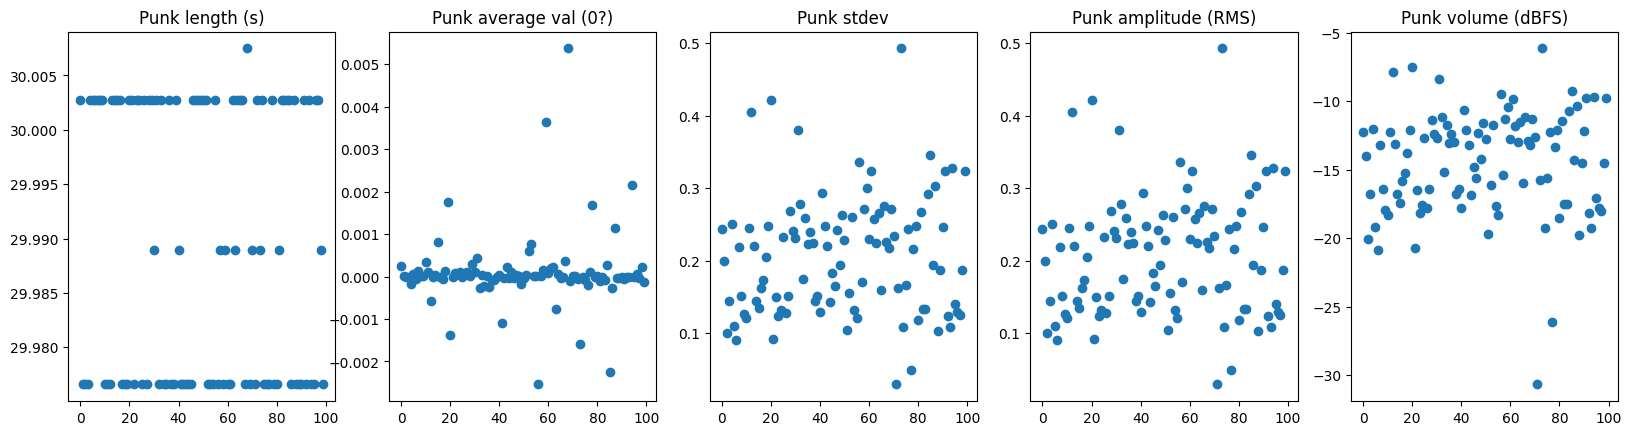

Genre:  Experimental
the max lenth of a  Experimental  track is  30.00269841269841
the min lenth of a  Experimental  track is  29.976575963718822
The most DC ofset is  0.022989718
The loudest  Experimental  track is  -5.194489435597952  dBFS
The quietest  Experimental  track is  -47.703693984267915  dBFS
The average  Experimental  track is  -16.317061145875876  dBFS


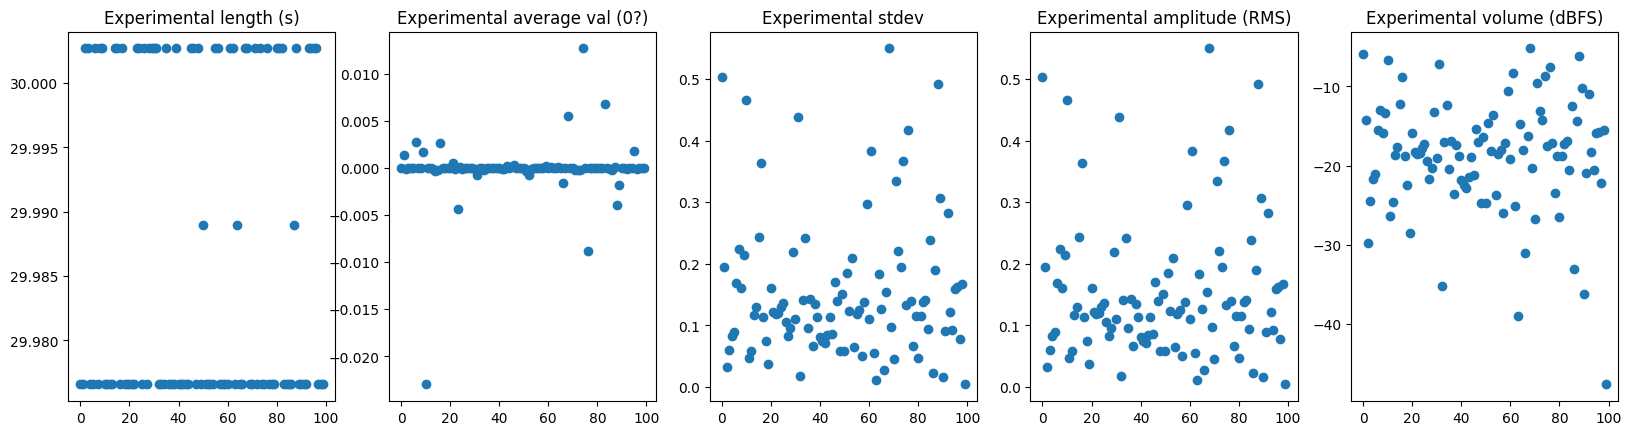

Genre:  Hip-Hop
the max lenth of a  Hip-Hop  track is  30.00269841269841
the min lenth of a  Hip-Hop  track is  1.5292290249433107
The most DC ofset is  0.16694768
The loudest  Hip-Hop  track is  -6.210996256023188  dBFS
The quietest  Hip-Hop  track is  -22.854160202464175  dBFS
The average  Hip-Hop  track is  -12.395247240108345  dBFS


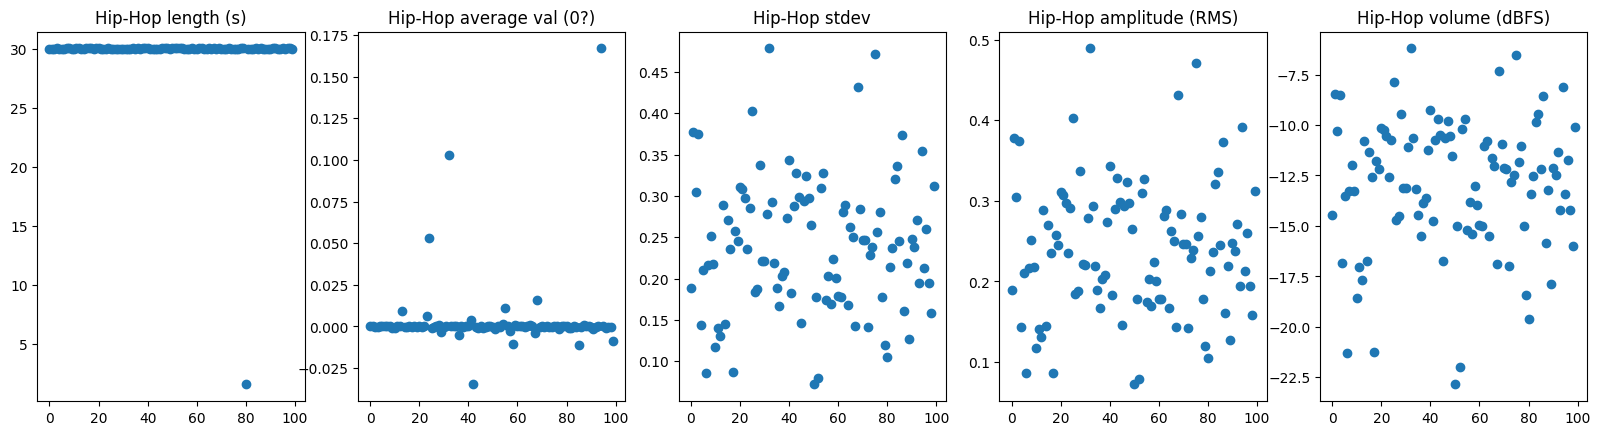

Genre:  Folk
the max lenth of a  Folk  track is  30.00269841269841
the min lenth of a  Folk  track is  29.976575963718822
The most DC ofset is  0.126884
The loudest  Folk  track is  -10.440534691216033  dBFS
The quietest  Folk  track is  -31.924558053907475  dBFS
The average  Folk  track is  -16.597002992287912  dBFS


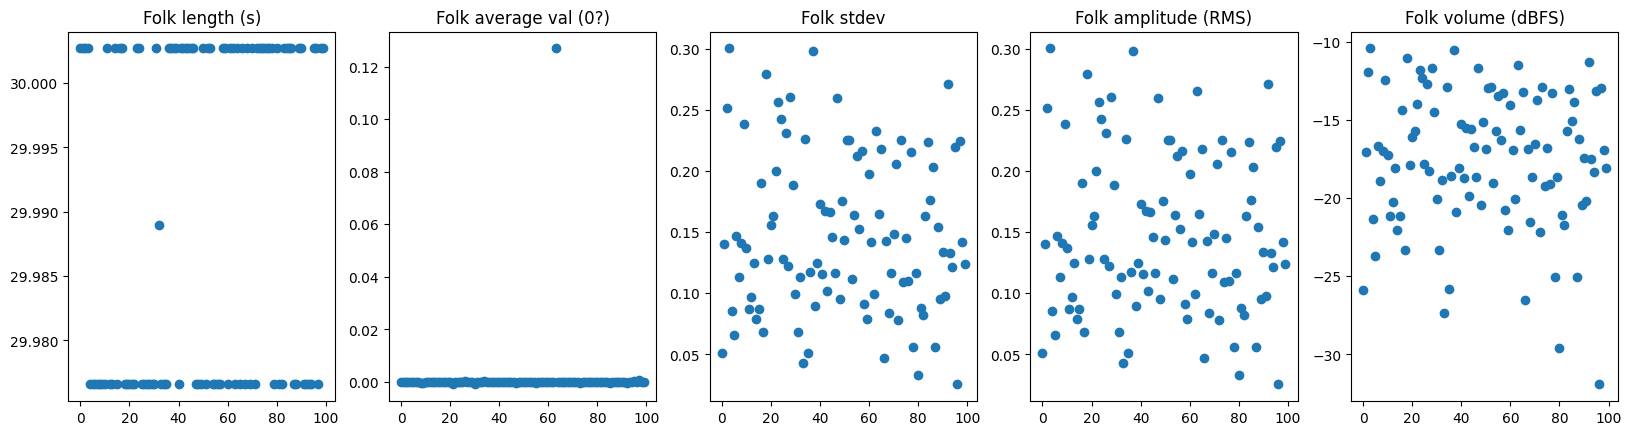

Genre:  Chiptune / Glitch
the max lenth of a  Chiptune / Glitch  track is  30.00269841269841
the min lenth of a  Chiptune / Glitch  track is  29.976575963718822
The most DC ofset is  0.033537943
The loudest  Chiptune / Glitch  track is  -4.680576161498223  dBFS
The quietest  Chiptune / Glitch  track is  -22.06552182353271  dBFS
The average  Chiptune / Glitch  track is  -12.254720812699551  dBFS


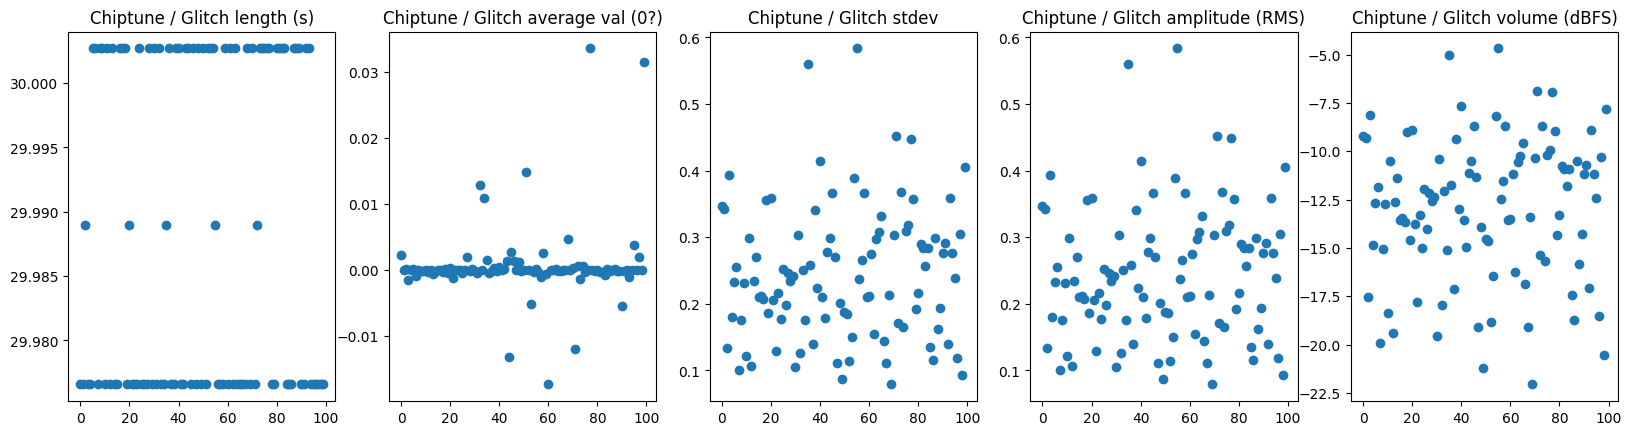

Genre:  Instrumental
the max lenth of a  Instrumental  track is  30.00269841269841
the min lenth of a  Instrumental  track is  29.976575963718822
The most DC ofset is  0.010670475
The loudest  Instrumental  track is  -4.65900650649389  dBFS
The quietest  Instrumental  track is  -34.17644854228625  dBFS
The average  Instrumental  track is  -16.74573121649695  dBFS


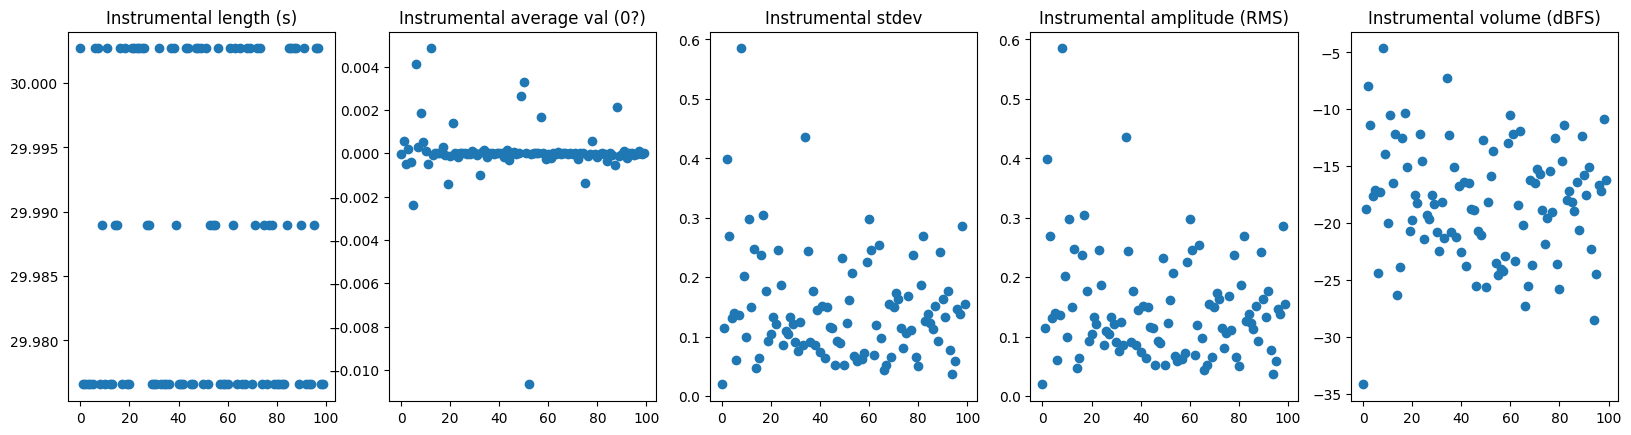

Genre:  Pop
the max lenth of a  Pop  track is  30.00269841269841
the min lenth of a  Pop  track is  29.976575963718822
The most DC ofset is  0.31705937
The loudest  Pop  track is  -4.7095802866185235  dBFS
The quietest  Pop  track is  -28.937310406967907  dBFS
The average  Pop  track is  -13.437003785891497  dBFS


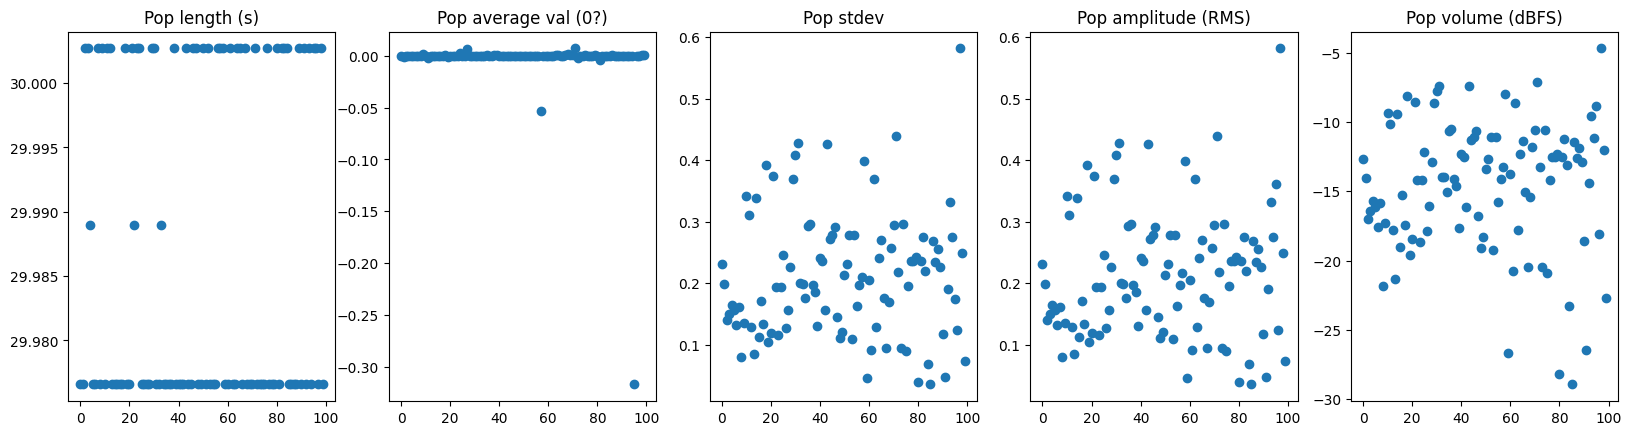

Genre:  International
the max lenth of a  International  track is  30.00269841269841
the min lenth of a  International  track is  29.964580498866212
The most DC ofset is  0.0047479747
The loudest  International  track is  -9.632865958929557  dBFS
The quietest  International  track is  -49.41417654292121  dBFS
The average  International  track is  -15.627075544554325  dBFS


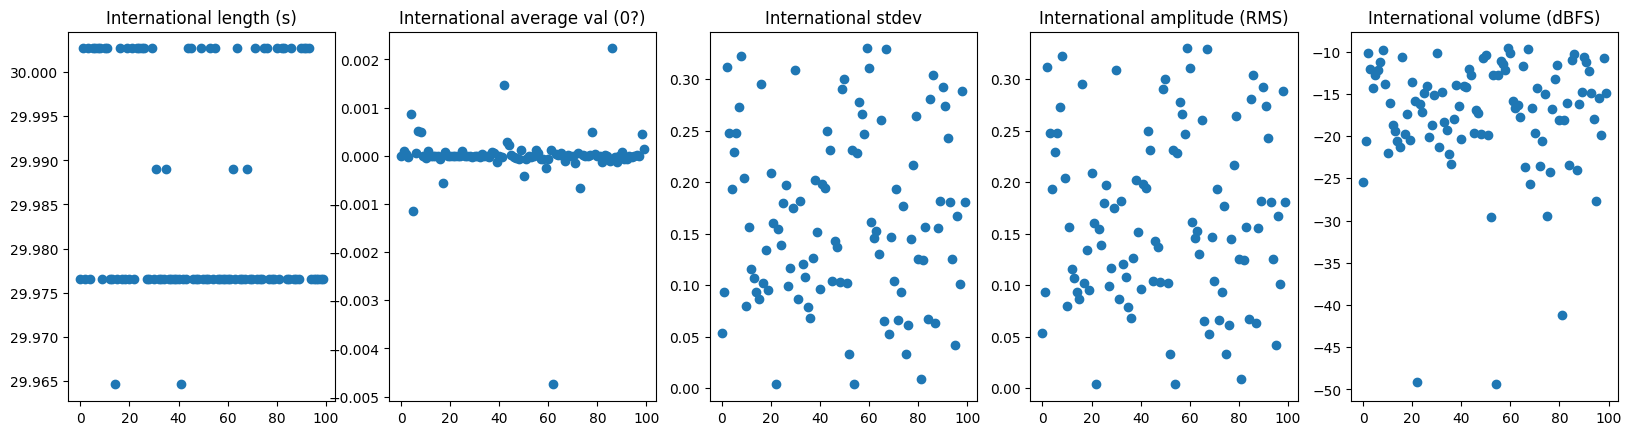

In [105]:
for i in range(10):
    myindex = df[df['genre_id'] == i].index
    newarray = [np.array(song['array'], dtype = np.float32) for song in songs[myindex]['audio']]


    lengths = []
    averages = []
    stdevs = []
    amps = []
    vols = []

    for song in newarray:
        lengths.append(len(song))
        averages.append(np.mean(song))
        stdevs.append(np.std(song))
        amps.append(np.sqrt(np.sum(song**2)/len(song)))
        vols.append(20*np.log10(amps[-1]))

    calculatestats(i, lengths, averages, stdevs, amps, vols)
    makegraphs(i, lengths, averages, stdevs, amps, vols)


In [ ]:
print("Longest song", max(lengths))
print("Shortest song", min(lengths))
print("Average song", np.mean(lengths))

Longest song 1323330
Shortest song 67439
Average song 1321201.963


Note: Some of the songs have different sampling rates, the most common being 44,100, 48,000, 32,000, and finally 22,050.

We want to either resample or reupload (like I did with song_786) to standardize this.



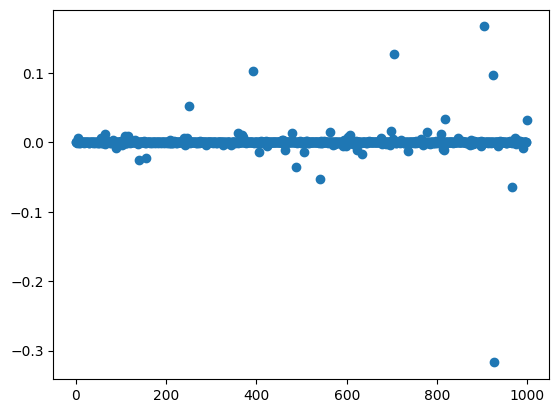

In [ ]:
plt.scatter(range(1000), np.array(averages))


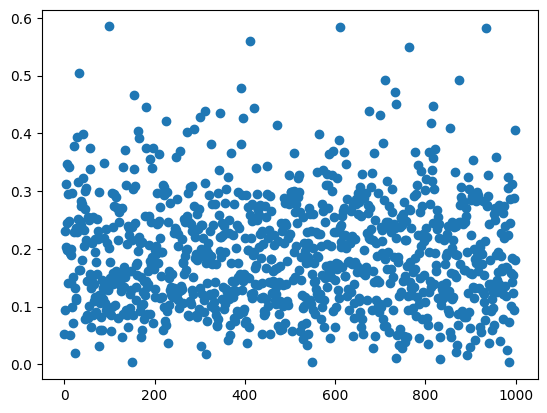

In [ ]:
plt.scatter(range(1000), np.array(stdevs))


In [ ]:
plt.scatter(range(1000), np.array(lengths)/44100)


#Summary Statistics

In [ ]:
averages = np.mean(sounds, axis = 0)
stdevs = np.std(sounds, axis = 0)

len(averages)

In [ ]:
np.std(songs['audio']['array'])

In [ ]:
sounds[786] =